# Give me Attention! ... in Image Classification (with Fashion MNIST)

Contributor: michaelmenzel@google.com

Various experiments which explore attention mechanisms and their influence on prediction accuracy and complexity. This notebook focuses on experiments with Vision Transformer (ViT).

In [2]:
#@title Imports
!pip install --upgrade -q matplotlib
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
if matplotlib.__version__ < '3.4.2':
  print('Need to restart runtime. Please rerun the cells.')
  import os
  os.kill(os.getpid(), 9)

import matplotlib.pyplot as plt
from matplotlib import gridspec

matplotlib: 3.4.2


In [3]:
#@title Load Fashion MNIST
(mnist_train, mnist_test), mnist_info = tfds.load("fashion_mnist", split=["train", "test"], as_supervised=True, with_info=True)

mnist_train = mnist_train.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_train_batched = mnist_train.batch(128).prefetch(tf.data.AUTOTUNE)
mnist_test = mnist_test.map(lambda x, y: (tf.squeeze(x/255, axis=-1), y))
mnist_test_batched = mnist_test.batch(128).prefetch(tf.data.AUTOTUNE)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJU3ZG5/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJU3ZG5/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
#@title Configuration

num_classes = mnist_info.features['label'].num_classes
image_size = mnist_info.features['image'].shape[0]
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

Following several helper functions and classes to construct the model and plot samples.

In [5]:
#@title Helper Functions
def mlp(input, hidden_units, dropout_rate):
    for units in hidden_units:
        dense = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(input)
        dropout = tf.keras.layers.Dropout(dropout_rate)(dense)
    return dropout

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def attention_map(mha_outs):
  mha_img = tf.reshape(
    tf.transpose(tf.stack(mha_outs), perm=[2, 0, 1, 3, 4]), 
    shape=[-1, transformer_layers, num_heads, image_size, image_size])
  mha_img = tf.math.reduce_mean(mha_img, axis=2)
  mha_img += tf.eye(mha_img.shape[-2])
  mha_img, _ = tf.linalg.normalize(mha_img, ord=2, axis=-2)

  v = mha_img[:,-1]
  for n in range(1, mha_img.shape[1]):
      v = tf.matmul(v, mha_img[:,-1 - n])
  return v

def plot_test_sample(model):
  fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

  for i, sample in enumerate(mnist_test.batch(1).take(10)):
    axs[0,i].imshow(sample[0][0], cmap='inferno')
    predicted = model(sample[0])
    axs[1,i].imshow(predicted['mha'][0], vmin=0, vmax=1, cmap='inferno')
    print(f'actual: {sample[1][0]}, predicted: {tf.argmax(predicted["class_one_hot"][0])}')

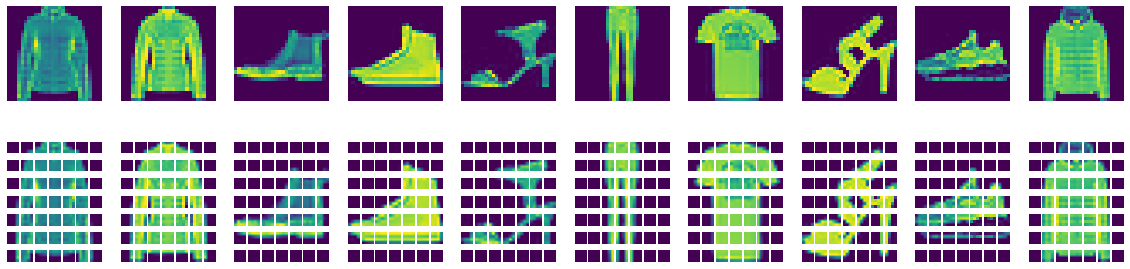

In [6]:
#@title Plot Sample
fig = plt.figure(figsize=(20, 5))
grid = fig.add_gridspec(2, 10)

for i, sample in enumerate(mnist_test.take(10)):
  ax0 = fig.add_subplot(grid[0,i])
  ax0.imshow(sample[0], vmin=0, vmax=1)
  ax0.set_axis_off()

  sample_patches = Patches(patch_size)([tf.expand_dims(sample[0], axis=-1)])
  patched_grid = grid[1,i].subgridspec(image_size // patch_size, image_size // patch_size)
  ax1 = patched_grid.subplots().flatten()
  
  for i, patch in enumerate(sample_patches[0]):
      patch_img = tf.reshape(patch, (patch_size, patch_size))
      ax1[i].imshow(patch_img, vmin=0, vmax=1)
      ax1[i].set_axis_off()

fig.show()

In [7]:
input = tf.keras.layers.Input(shape=(image_size,image_size, 1))

patches = Patches(patch_size)(input)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

mhas = []
for i in range(transformer_layers):
        normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(normed, normed)
        mhas.append(tf.stack(tf.split(attention_output, num_heads, axis=-1)))
        skip_merge = tf.keras.layers.Add()([attention_output, encoded_patches])
        normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip_merge)
        features = mlp(normed, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = skip_merge2 = tf.keras.layers.Add()([features, skip_merge])

output_mha = attention_map(mhas)

normed = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip_merge2)
flat = tf.keras.layers.Flatten()(normed)
dropout = tf.keras.layers.Dropout(0.5)(flat)
features = mlp(dropout, hidden_units=mlp_head_units, dropout_rate=0.5)
output = tf.keras.layers.Dense(num_classes)(features)

model = tf.keras.Model(inputs=input, outputs={'class_one_hot': output, 'mha': output_mha})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
patches_10 (Patches)            (None, None, 16)     0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 49, 64)       4224        patches_10[0][0]                 
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 49, 64)       128         patch_encoder[0][0]              
______________________________________________________________________________________________

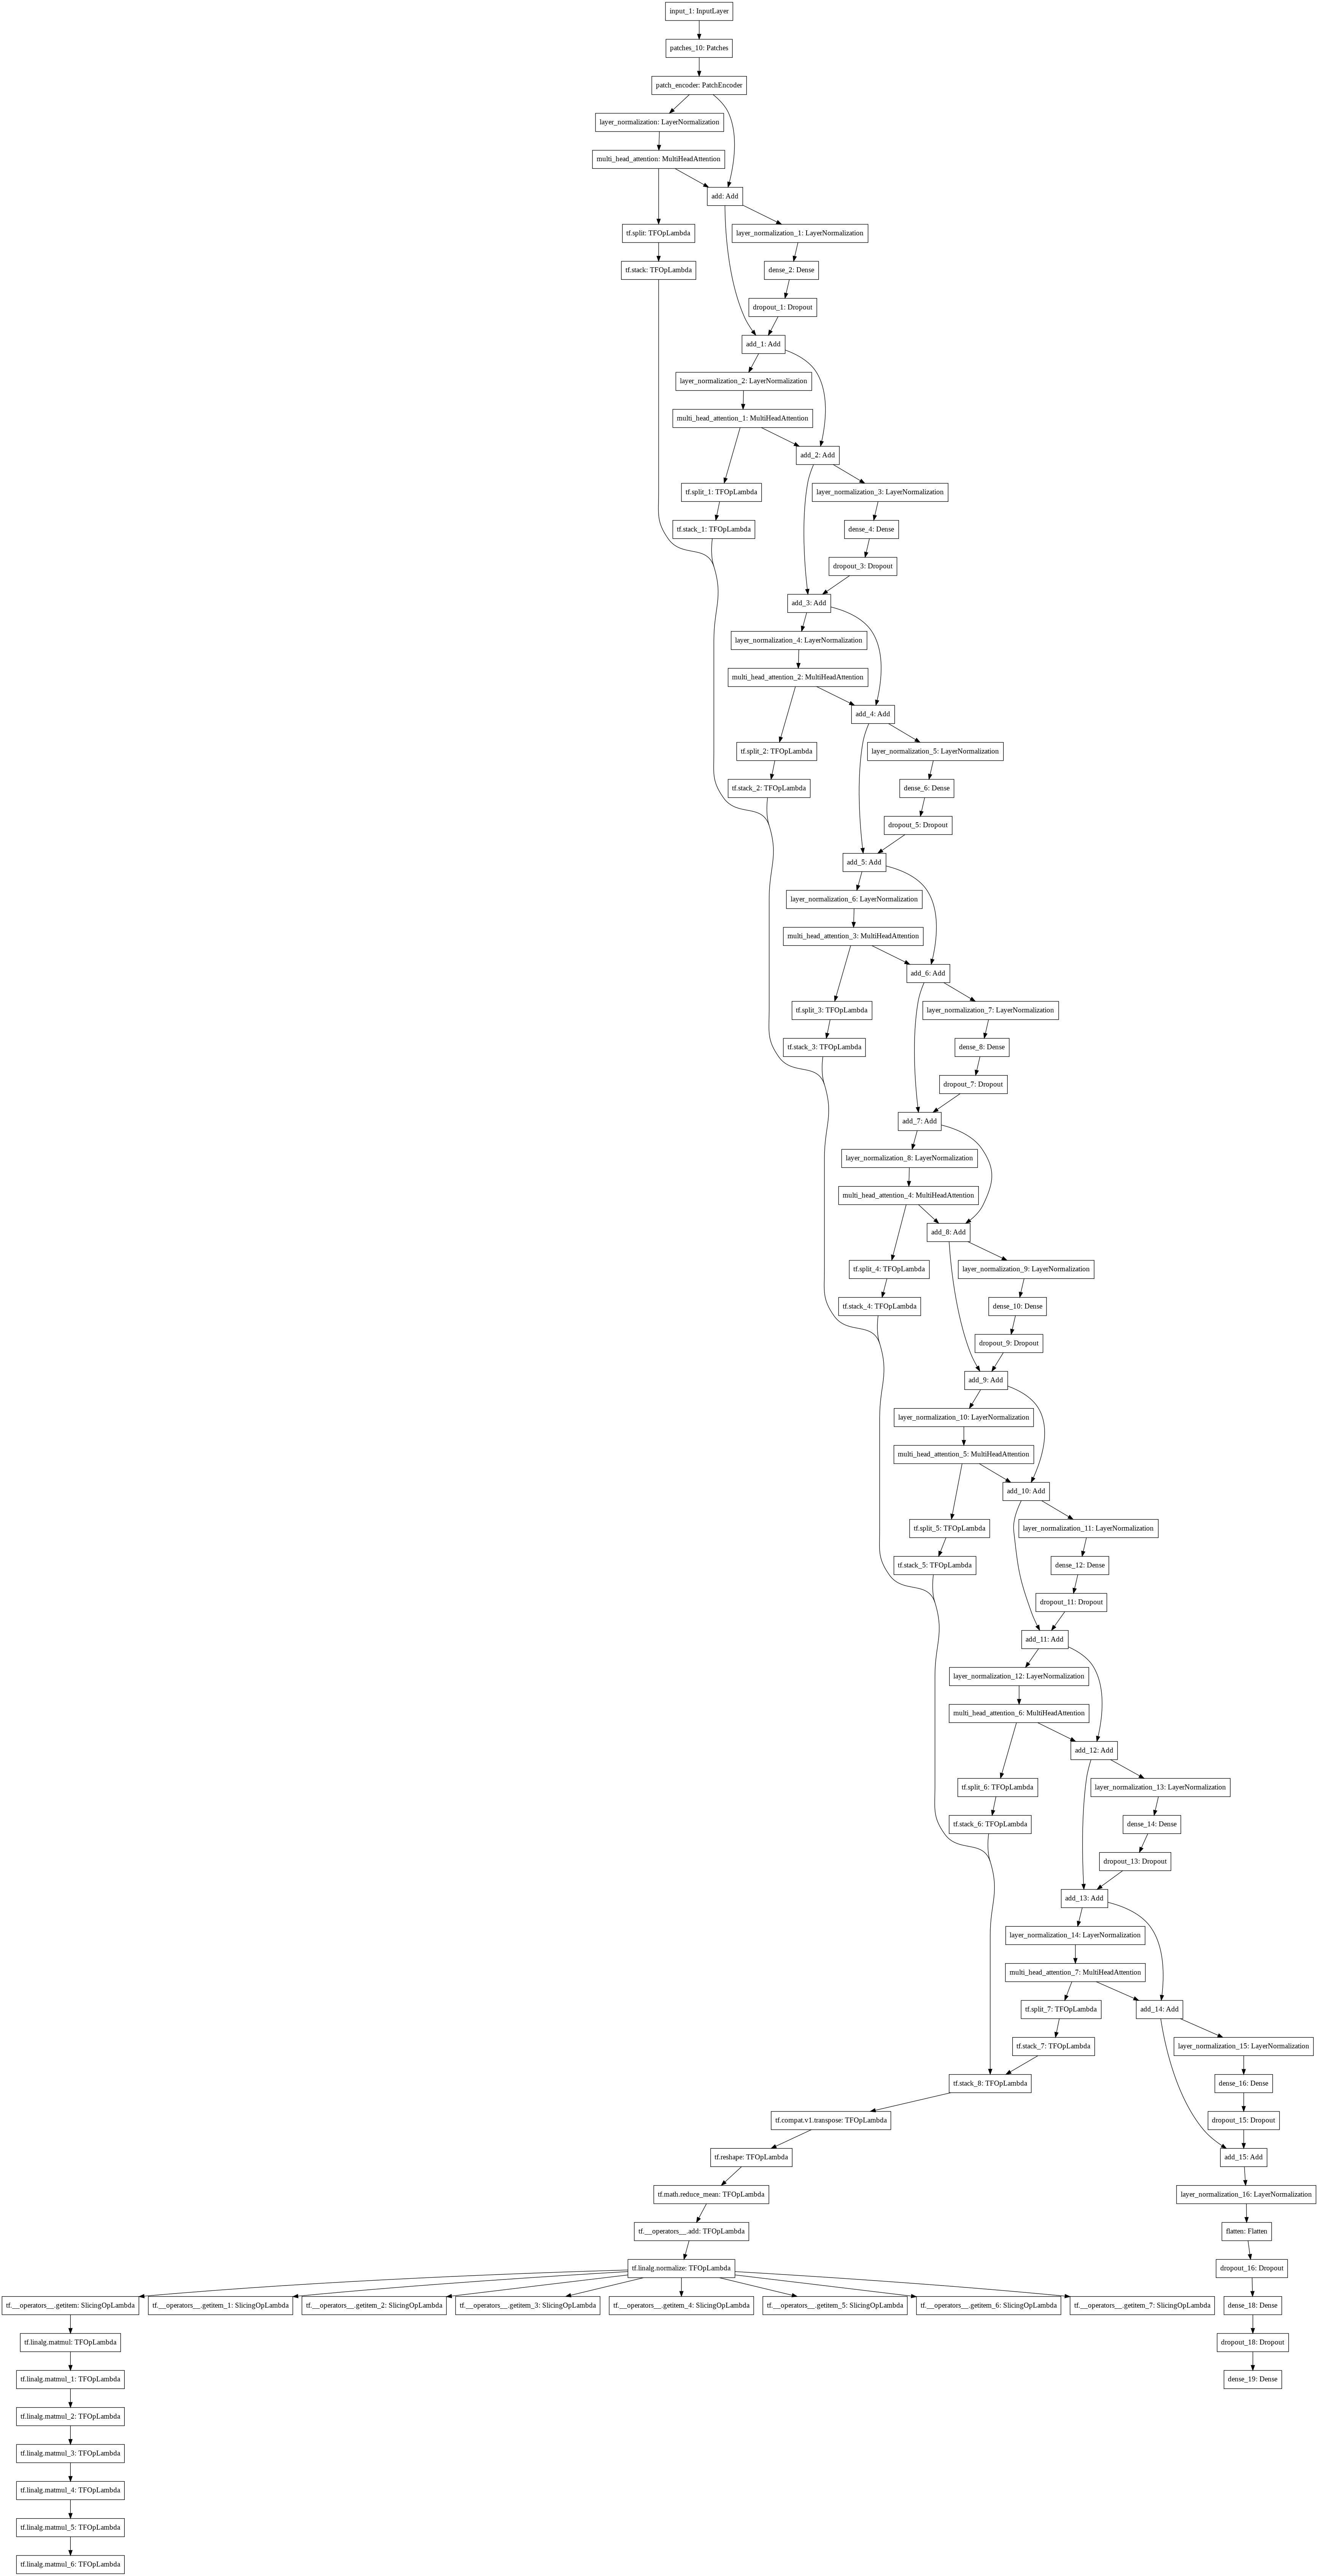

In [8]:
tf.keras.utils.plot_model(model)

In [11]:
model.compile(optimizer='adam', 
              loss={'class_one_hot': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'mha': lambda x,y: 0}, 
              metrics={'class_one_hot': tf.keras.metrics.SparseCategoricalAccuracy(), 'mha': 'accuracy'})
model.fit(mnist_train_batched, validation_data=mnist_test_batched, epochs=20)

Epoch 1/10
469/469 [==============================] - 32s 55ms/step - loss: 0.2754 - dense_19_loss: 0.2754 - tf.linalg.matmul_6_loss: 0.0000e+00 - dense_19_sparse_categorical_accuracy: 0.8970 - tf.linalg.matmul_6_accuracy: 0.0396 - val_loss: 0.2792 - val_dense_19_loss: 0.2792 - val_tf.linalg.matmul_6_loss: 0.0000e+00 - val_dense_19_sparse_categorical_accuracy: 0.9023 - val_tf.linalg.matmul_6_accuracy: 0.0331
Epoch 2/10
469/469 [==============================] - 31s 66ms/step - loss: 0.2582 - dense_19_loss: 0.2582 - tf.linalg.matmul_6_loss: 0.0000e+00 - dense_19_sparse_categorical_accuracy: 0.9049 - tf.linalg.matmul_6_accuracy: 0.0376 - val_loss: 0.2710 - val_dense_19_loss: 0.2710 - val_tf.linalg.matmul_6_loss: 0.0000e+00 - val_dense_19_sparse_categorical_accuracy: 0.9019 - val_tf.linalg.matmul_6_accuracy: 0.0329
Epoch 3/10
469/469 [==============================] - 29s 63ms/step - loss: 0.2487 - dense_19_loss: 0.2487 - tf.linalg.matmul_6_loss: 0.0000e+00 - dense_19_sparse_categorical_a

actual: 4, predicted: 4
actual: 4, predicted: 4
actual: 9, predicted: 9
actual: 7, predicted: 9
actual: 5, predicted: 5
actual: 1, predicted: 1
actual: 0, predicted: 0
actual: 5, predicted: 5
actual: 7, predicted: 7
actual: 4, predicted: 4


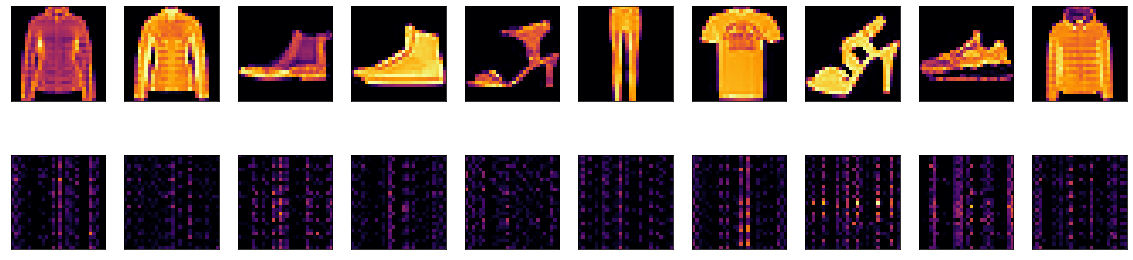

In [13]:
plot_test_sample(model)